# Data Processing

In [ ]:
# Necessary Imports
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load in data
def load_data(file_path, skiprows):
    # Read the file with the specified number of rows to skip
    df = pd.read_csv(file_path, skiprows=skiprows, dtype=str)

    # Strip spaces from the column names
    df.columns = df.columns.str.strip()

    # Strip extra spaces in the data cells
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    # Drop non-data rows (e.g., headers embedded in data)
    df = df[~df.iloc[:, 0].str.contains("Average", na=False)]

    # Convert the first column to datetime format (assuming it's the index)
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], format='%Y%m%d', errors='coerce')

    # Drop any rows where the date couldn't be parsed
    df = df.dropna(subset=[df.columns[0]])

    # Set the first column as the index
    df.set_index(df.columns[0], inplace=True)

    # Convert all remaining columns to numeric, replacing errors with NaN
    df = df.apply(pd.to_numeric, errors='coerce')

    # Handle missing values
    df[df == -99.99] = np.nan

    return df

# File paths
industry_file = "/49_Industry_Portfolios_Daily.csv"
market_file = "/Developed_3_Factors_Daily.csv"

# Load the data with the correct number of rows to skip
industry_returns = load_data(industry_file, skiprows=9)
market_returns = load_data(market_file, skiprows=6)

# Small erroneous fix
market_returns.index = pd.to_datetime(market_returns.index, errors='coerce')

# Replace -99.99 with NaN in the industry returns data
industry_returns.replace(-99.99, np.nan, inplace=True)

# Truncate the industry data to match the market data's start date
industry_returns = industry_returns[(industry_returns.index >= market_returns.index[0]) &
                                    (industry_returns.index <= market_returns.index[-1])]

# There are some large gaps because of many missing values in the industry_returns dataset

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.

/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.



In [ ]:
# Summary of the cleaned data
print("Cleaned Industry Data (first 5 rows):")
print(industry_returns.head())
print("\nCleaned Market Data (first 5 rows):")
print(market_returns.head())

Cleaned Industry Data (first 5 rows):
            Agric  Food  Soda  Beer  Smoke  Toys   Fun  Books  Hshld  Clths  \
Unnamed: 0                                                                    
1990-07-02  -1.22  0.63 -0.72  0.32  -0.40 -3.98 -0.11  -0.85   0.80   0.17   
1990-07-03   0.79  0.67  0.72  0.90   1.25  1.45  0.42  -0.02   0.17   0.13   
1990-07-05  -0.75 -1.24 -0.66 -1.39  -0.30 -1.41 -0.85  -0.91  -1.15  -1.12   
1990-07-06   0.24  2.01 -2.25  1.55   1.12  0.56  0.91  -0.08   0.54   1.69   
1990-07-09  -1.05  0.29 -2.92 -0.80   1.18  0.33  0.97   0.95   0.31   1.10   

            ...  Boxes  Trans  Whlsl  Rtail  Meals  Banks  Insur  RlEst   Fin  \
Unnamed: 0  ...                                                                 
1990-07-02  ...  -0.70  -0.12   0.37   0.38   0.06  -0.01   0.25  -0.38 -0.09   
1990-07-03  ...   0.38  -0.03  -0.10   0.29   0.32  -0.25  -0.14  -1.00  0.08   
1990-07-05  ...  -0.46  -1.09  -0.85  -0.96  -1.09  -1.30  -1.06  -0.40 -0.62   
199

# Capital Asset Pricing Model - Betas

In [ ]:
# Compute Monthly CAPM Betas
def compute_beta(industry_returns, market_returns):
    combined_returns = industry_returns.join(market_returns, how='inner', rsuffix='_Mkt')
    monthly_betas = {}

    for industry in industry_returns.columns:
        monthly_betas[industry] = combined_returns.groupby(combined_returns.index.to_period('M')).apply(
            lambda x: np.cov(x[industry], x['Mkt-RF'])[0, 1] / np.var(x['Mkt-RF']) if len(x) > 1 else np.nan
        )

    return pd.DataFrame(monthly_betas)

monthly_betas = compute_beta(industry_returns, market_returns)

In [ ]:
# Print summary statistics for monthly betas
print("\nMonthly Betas Summary (mean, std, min, max) for each industry:")
print(monthly_betas.describe())


Monthly Betas Summary (mean, std, min, max) for each industry:
            Agric        Food        Soda        Beer       Smoke        Toys  \
count  412.000000  412.000000  412.000000  412.000000  412.000000  412.000000   
mean     0.776719    0.591248    0.645409    0.561437    0.625144    0.917151   
std      0.477313    0.301743    0.478235    0.358554    0.504411    0.489152   
min     -0.975944   -0.483927   -1.694337   -0.736563   -1.985920   -0.492788   
25%      0.506814    0.408155    0.394221    0.344377    0.338304    0.644945   
50%      0.767903    0.597943    0.688674    0.573567    0.613290    0.884162   
75%      1.080887    0.783693    0.958553    0.769461    0.872503    1.196442   
max      2.249514    1.685589    2.259611    1.566119    2.190218    2.706306   

              Fun       Books       Hshld       Clths  ...       Boxes  \
count  412.000000  412.000000  412.000000  412.000000  ...  412.000000   
mean     1.070435    0.910430    0.759803    0.952373  ...

In [ ]:
from scipy.stats import zscore

# Compute Z-scores for monthly betas
z_scores = monthly_betas.apply(zscore, axis=0)
outliers = (z_scores.abs() > 3).sum()
print(f"\nNumber of outliers (Z-score > 3) in monthly betas for each industry:")
print(outliers)


Number of outliers (Z-score > 3) in monthly betas for each industry:
Agric    2
Food     4
Soda     8
Beer     2
Smoke    5
Toys     3
Fun      4
Books    2
Hshld    2
Clths    1
Hlth     2
MedEq    2
Drugs    3
Chems    1
Rubbr    1
Txtls    3
BldMt    3
Cnstr    0
Steel    2
FabPr    3
Mach     2
ElcEq    2
Autos    1
Aero     4
Ships    3
Guns     2
Gold     2
Mines    1
Coal     2
Oil      3
Util     2
Telcm    2
PerSv    1
BusSv    0
Hardw    5
Softw    7
Chips    4
LabEq    5
Paper    2
Boxes    5
Trans    1
Whlsl    4
Rtail    2
Meals    1
Banks    3
Insur    2
RlEst    4
Fin      1
Other    3
dtype: int64


In [ ]:
def identify_volatile_industries(betas):
    volatility = betas.std()
    most_volatile = volatility.idxmax()
    least_volatile = volatility.idxmin()
    return most_volatile, least_volatile

most_volatile, least_volatile = identify_volatile_industries(monthly_betas)
print(f"\nMost Volatile Industry: {most_volatile}")
print(f"Least Volatile Industry: {least_volatile}")


Most Volatile Industry: Gold
Least Volatile Industry: Food


In [1]:
# Convert the index to datetime to resolve the 'Period' issue
monthly_betas.index = monthly_betas.index.to_timestamp()

# Create the figure for Monthly Betas
fig = go.Figure()

for industry in monthly_betas.columns:
    fig.add_trace(go.Scatter(x=monthly_betas.index, y=monthly_betas[industry], mode='lines', name=industry))

fig.update_layout(
    title="Monthly CAPM Betas of 49 Industries",
    xaxis_title="Time",
    yaxis_title="Beta",
    template="plotly_dark",
    height=600,
    width=800
)

fig.show()

NameError: name 'monthly_betas' is not defined

In [ ]:
# Industry Beta Volatility Calculation
volatility = monthly_betas.std(axis=0)
for industry, vol in volatility.items():
    if vol > 0.8:  # Industries with high volatility
        print(f"Industry {industry} has high beta volatility and may require risk mitigation strategies.")


Industry Gold has high beta volatility and may require risk mitigation strategies.
Industry Coal has high beta volatility and may require risk mitigation strategies.


# Principal Component Analysis

In [ ]:
# Perform PCA on Monthly Betas
pca = PCA()
pca.fit(monthly_betas.dropna())
explained_variance = pca.explained_variance_ratio_

In [ ]:
# Output the Percentage of Variance Explained by the Principal Components
print("\nPCA Results:")
print(f"Total number of principal components: {len(explained_variance)}")
print(f"Explained variance by each principal component: {explained_variance}")
print(f"Cumulative explained variance: {np.cumsum(explained_variance)}")
print("\nInterpretation of PCA Results:")
print("The first principal component (PC1) captures the largest proportion of variance in the data.")
print("As you move down the list of principal components, each one captures progressively smaller amounts of variance.")


PCA Results:
Total number of principal components: 49
Explained variance by each principal component: [0.44284564 0.13235508 0.06354709 0.05411851 0.0359494  0.02343739
 0.02130254 0.01631697 0.0149149  0.01328397 0.01284342 0.01177729
 0.01091681 0.00998272 0.00884242 0.00833931 0.00796211 0.00770889
 0.00717692 0.00678889 0.00636035 0.00613836 0.00578544 0.00531164
 0.00521898 0.00487895 0.00453108 0.00423825 0.00393423 0.00373996
 0.00338701 0.00332241 0.0030457  0.00303237 0.00290417 0.00255885
 0.00234549 0.00218489 0.00206456 0.0019016  0.00182288 0.00173801
 0.00170859 0.00157993 0.00147169 0.00132505 0.00129084 0.00110751
 0.00066093]
Cumulative explained variance: [0.44284564 0.57520073 0.63874782 0.69286632 0.72881572 0.75225311
 0.77355565 0.78987262 0.80478752 0.8180715  0.83091492 0.84269221
 0.85360902 0.86359174 0.87243416 0.88077347 0.88873558 0.89644447
 0.90362139 0.91041028 0.91677063 0.92290899 0.92869443 0.93400607
 0.93922505 0.94410399 0.94863508 0.95287332 0.95

In [ ]:
# Create the figure for PCA Cumulative Explained Variance
fig_pca = go.Figure()

fig_pca.add_trace(go.Scatter(
    x=list(range(1, len(explained_variance) + 1)),
    y=np.cumsum(explained_variance),
    mode='lines+markers',
    name='Cumulative Explained Variance'
))

fig_pca.update_layout(
    title="PCA of Monthly CAPM Betas",
    xaxis_title="Number of Principal Components",
    yaxis_title="Cumulative Explained Variance",
    template="plotly_dark",
    height=500,
    width=800
)

fig_pca.show()

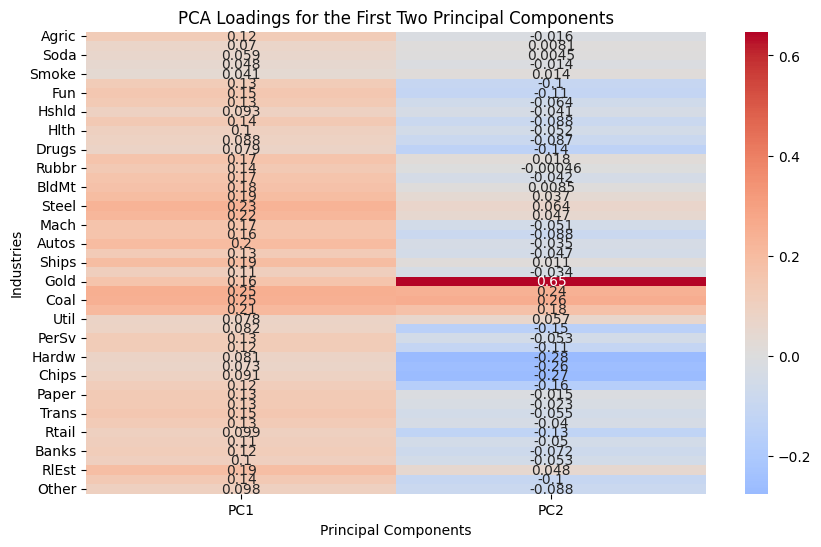

In [ ]:
# PCA Loadings to Understand Component Contribution
pca_components = pca.components_
pca_loadings = pd.DataFrame(pca_components.T, columns=[f"PC{i+1}" for i in range(len(pca_components))], index=monthly_betas.columns)

# Visualizing the PCA Loadings for the First Two Principal Components
plt.figure(figsize=(10, 6))
sns.heatmap(pca_loadings.iloc[:, :2], annot=True, cmap='coolwarm', center=0)
plt.title("PCA Loadings for the First Two Principal Components")
plt.xlabel("Principal Components")
plt.ylabel("Industries")
plt.show()

# Clustering Fun

In [ ]:
from sklearn.cluster import KMeans

# Apply k-means clustering to group industries
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(monthly_betas.T)

print("\nIndustry Clusters (based on risk profile):")
industry_clusters = pd.DataFrame(clusters, index=monthly_betas.columns, columns=["Cluster"])
print(industry_clusters)

# Plot the clustering results
fig_cluster = go.Figure()

for cluster in np.unique(clusters):
    fig_cluster.add_trace(go.Scatter(x=monthly_betas.columns[clusters == cluster],
                                    y=[monthly_betas[industry].mean() for industry in monthly_betas.columns[clusters == cluster]],
                                    mode='markers', name=f"Cluster {cluster}"))

fig_cluster.update_layout(
    title="Industry Clusters Based on Risk Profile",
    xaxis_title="Industries",
    yaxis_title="Average Beta",
    template="plotly_dark"
)
fig_cluster.show()



Industry Clusters (based on risk profile):
       Cluster
Agric        0
Food         0
Soda         0
Beer         0
Smoke        0
Toys         1
Fun          1
Books        1
Hshld        0
Clths        1
Hlth         0
MedEq        0
Drugs        2
Chems        1
Rubbr        1
Txtls        1
BldMt        1
Cnstr        1
Steel        1
FabPr        1
Mach         1
ElcEq        1
Autos        1
Aero         1
Ships        1
Guns         0
Gold         3
Mines        1
Coal         1
Oil          1
Util         0
Telcm        2
PerSv        1
BusSv        1
Hardw        2
Softw        2
Chips        2
LabEq        2
Paper        1
Boxes        1
Trans        1
Whlsl        1
Rtail        1
Meals        0
Banks        1
Insur        0
RlEst        1
Fin          1
Other        0


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Preprocess the data by scaling the betas
scaler = StandardScaler()
scaled_betas = scaler.fit_transform(monthly_betas.dropna())

# Function to compute silhouette scores for a range of k values
def silhouette_analysis(scaled_betas, max_k=10):
    silhouette_scores = []
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(scaled_betas)
        score = silhouette_score(scaled_betas, cluster_labels)
        silhouette_scores.append((k, score))
    return silhouette_scores

# Perform silhouette analysis to determine the best k
silhouette_scores = silhouette_analysis(scaled_betas, max_k=10)

# Find the best k based on silhouette score
best_k = max(silhouette_scores, key=lambda x: x[1])[0]
print(f"Optimal number of clusters (k): {best_k}")

# Apply k-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42)
monthly_betas['Cluster'] = kmeans.fit_predict(scaled_betas)

# Visualizing the clusters with industry names when hovering
clustered_data = monthly_betas.copy()
clustered_data['Industry'] = clustered_data.index

# Plot the clusters with interactive hover info showing industry names
fig_clusters = px.scatter(clustered_data, x=clustered_data.index, y=clustered_data['Cluster'],
                          color='Cluster', hover_name='Industry',
                          labels={"x": "Time", "y": "Cluster ID", "Cluster": "Cluster"},
                          title=f"Industry Clusters Based on CAPM Betas (k={best_k})")
fig_clusters.update_traces(marker=dict(size=12))
fig_clusters.update_layout(showlegend=True)
fig_clusters.show()

Optimal number of clusters (k): 2


In [ ]:
print("\nInterpretation of Silhouette Analysis:")
print("The silhouette score measures how well each point lies within its cluster. A higher score indicates better-defined clusters.")
print("By varying the number of clusters, we can determine the optimal number of clusters for grouping the industries based on their monthly beta values.")


Interpretation of Silhouette Analysis:
The silhouette score measures how well each point lies within its cluster. A higher score indicates better-defined clusters.
By varying the number of clusters, we can determine the optimal number of clusters for grouping the industries based on their monthly beta values.


# Summary

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go

# Assuming `monthly_betas` is your DataFrame with the monthly betas of 49 industries

# PCA Analysis
pca = PCA()
pca.fit(monthly_betas.dropna())
explained_variance = pca.explained_variance_ratio_

# Print PCA Findings
print("### PCA Analysis ###")
print(f"Cumulative Explained Variance of Principal Components:")
for i, var in enumerate(np.cumsum(explained_variance), 1):
    print(f"PC {i}: {var:.4f}")

# Actionable Insight from PCA
print("\n### Actionable Insights from PCA ###")
if np.cumsum(explained_variance)[0] > 0.7:
    print("The first principal component explains a significant portion of the variation (over 70%), indicating that a small number of market-wide factors dominate the betas of the industries. Consider focusing on these macroeconomic factors in your investment strategy.")
else:
    print("The first principal component does not explain a large portion of the variation, suggesting that sector-specific factors may be more important in driving the betas. Diversification across sectors may reduce exposure to these specific risks.")

# Cluster Analysis (K-means)
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(monthly_betas.dropna())

# Add cluster labels to monthly_betas for visualization and reporting
monthly_betas['Cluster'] = cluster_labels

# Silhouette Score for Cluster Validation
silhouette_avg = silhouette_score(monthly_betas.dropna(), cluster_labels)
print(f"\nSilhouette Score for Clustering: {silhouette_avg:.4f}")
if silhouette_avg > 0.5:
    print("The clustering is well-defined and meaningful (Silhouette score > 0.5).")
else:
    print("The clustering might not be well-defined (Silhouette score < 0.5). Consider adjusting the number of clusters.")

# Print Cluster Insights
print("\n### Actionable Insights from Clustering ###")
for cluster_id in np.unique(cluster_labels):
    industries_in_cluster = monthly_betas[monthly_betas['Cluster'] == cluster_id].index.tolist()
    print(f"Cluster {cluster_id}: Industries in this cluster have similar sensitivities to market-wide risk factors.")
    print(f"Industries: {industries_in_cluster}")

    # Example action for risk mitigation
    if cluster_id == 0:  # Example: if Cluster 0 represents high-volatility industries
        print(f"Action: Consider hedging strategies such as options or futures for industries in this cluster.")
    else:
        print(f"Action: Industries in this cluster may be more stable, providing diversification benefits to a portfolio.")

# Plotting the cluster analysis
fig_clusters = go.Figure()
for cluster_id in np.unique(cluster_labels):
    cluster_data = monthly_betas[monthly_betas['Cluster'] == cluster_id]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data.index,
        y=cluster_data.mean(axis=1),
        mode='markers',
        name=f"Cluster {cluster_id}"
    ))

fig_clusters.update_layout(title="Cluster Analysis of Industry Betas",
                           xaxis_title="Time",
                           yaxis_title="Beta",
                           showlegend=True)
fig_clusters.show()

# Volatility Analysis
volatility = monthly_betas.std(axis=1)

# Print Volatility Insights
print("\n### Volatility Analysis ###")
#for industry in monthly_betas.columns:
    #print(f"Industry {industry} - Volatility: {volatility[industry]:.4f}")

# Actionable Insight from Volatility
print("\n### Actionable Insights from Volatility ###")
high_volatility_industries = volatility[volatility > volatility.quantile(0.75)].index.tolist()
low_volatility_industries = volatility[volatility < volatility.quantile(0.25)].index.tolist()

print(f"High Volatility Industries (Top 25%): {high_volatility_industries}")
print(f"Low Volatility Industries (Bottom 25%): {low_volatility_industries}")

print("Actionable Insights:")
if high_volatility_industries:
    print(f"Consider hedging or implementing options strategies for high-volatility industries.")
if low_volatility_industries:
    print(f"Consider adding low-volatility industries to your portfolio for more stability.")

# Summary Report
print("\n### Summary Report ###")
print("The Principal Component Analysis reveals that a small number of factors explain a large portion of the variation in industry betas. This suggests that focusing on market-wide factors could improve your portfolio management.")
print("Cluster Analysis suggests that grouping industries based on their risk profiles (e.g., high volatility vs. low volatility) provides insights into diversification opportunities.")
print("Volatility analysis indicates which industries are more sensitive to market fluctuations and which can offer more stability.")

print("\n### Recommended Portfolio Strategy ###")
print("1. Hedge against market-wide risks with options or futures for industries highly exposed to the first principal component.")
print("2. Diversify across clusters to reduce exposure to systemic risks and sector-specific shocks.")
print("3. Consider incorporating both high-volatility and low-volatility industries into your portfolio for a balanced risk-return profile.")

### PCA Analysis ###
Cumulative Explained Variance of Principal Components:
PC 1: 0.3903
PC 2: 0.5491
PC 3: 0.6497
PC 4: 0.7023
PC 5: 0.7429
PC 6: 0.7722
PC 7: 0.7920
PC 8: 0.8095
PC 9: 0.8231
PC 10: 0.8357
PC 11: 0.8468
PC 12: 0.8576
PC 13: 0.8675
PC 14: 0.8767
PC 15: 0.8852
PC 16: 0.8926
PC 17: 0.8997
PC 18: 0.9064
PC 19: 0.9129
PC 20: 0.9189
PC 21: 0.9247
PC 22: 0.9300
PC 23: 0.9352
PC 24: 0.9401
PC 25: 0.9446
PC 26: 0.9490
PC 27: 0.9531
PC 28: 0.9569
PC 29: 0.9605
PC 30: 0.9638
PC 31: 0.9670
PC 32: 0.9698
PC 33: 0.9726
PC 34: 0.9752
PC 35: 0.9777
PC 36: 0.9802
PC 37: 0.9823
PC 38: 0.9842
PC 39: 0.9861
PC 40: 0.9878
PC 41: 0.9894
PC 42: 0.9909
PC 43: 0.9923
PC 44: 0.9938
PC 45: 0.9951
PC 46: 0.9963
PC 47: 0.9974
PC 48: 0.9985
PC 49: 0.9994
PC 50: 1.0000

### Actionable Insights from PCA ###
The first principal component does not explain a large portion of the variation, suggesting that sector-specific factors may be more important in driving the betas. Diversification across sectors


### Volatility Analysis ###

### Actionable Insights from Volatility ###
High Volatility Industries (Top 25%): [Timestamp('1990-09-01 00:00:00'), Timestamp('1991-01-01 00:00:00'), Timestamp('1991-03-01 00:00:00'), Timestamp('1991-09-01 00:00:00'), Timestamp('1991-10-01 00:00:00'), Timestamp('1992-02-01 00:00:00'), Timestamp('1992-03-01 00:00:00'), Timestamp('1992-07-01 00:00:00'), Timestamp('1992-10-01 00:00:00'), Timestamp('1992-11-01 00:00:00'), Timestamp('1992-12-01 00:00:00'), Timestamp('1993-01-01 00:00:00'), Timestamp('1993-02-01 00:00:00'), Timestamp('1993-04-01 00:00:00'), Timestamp('1993-05-01 00:00:00'), Timestamp('1993-10-01 00:00:00'), Timestamp('1994-02-01 00:00:00'), Timestamp('1994-05-01 00:00:00'), Timestamp('1994-07-01 00:00:00'), Timestamp('1995-02-01 00:00:00'), Timestamp('1995-07-01 00:00:00'), Timestamp('1995-11-01 00:00:00'), Timestamp('1995-12-01 00:00:00'), Timestamp('1996-09-01 00:00:00'), Timestamp('1996-10-01 00:00:00'), Timestamp('1997-01-01 00:00:00'), Tim